#### Install dependencies

In [1]:
!pip install -Uqq fastai duckduckgo_search

#### Define a function to search for images on DDG. Search for 90 images by default.

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=90):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

#### Lets see the an example of the URL we find using the above function

In [3]:
urls = search_images('duck', max_images=1)
urls[0]

Searching for 'duck'


'http://3.bp.blogspot.com/--XA3iMvaJLY/Tw_GykPs-eI/AAAAAAAAEgU/EmFKS7Cz5xQ/s1600/Duck-04.jpg'

#### What does this image look like? Is it actually a duck?

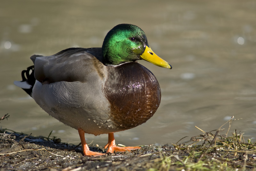

In [4]:
from fastdownload import download_url
dest = 'duck.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

#### How about a swan?

Searching for 'swan'


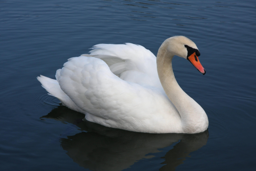

In [5]:
download_url(search_images('swan', max_images=1)[0], 'swan.jpg', show_progress=False)
Image.open('swan.jpg').to_thumb(256,256)

#### Looks like we are on the right path. So go ahead and download 90 of each. Might take a bit of time.

In [6]:
searches = 'duck','swan'
path = Path('duck_or_swan')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(30)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'duck photo'
Searching for 'swan photo'


#### Remove images that didn't get downloaded properly

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

#### The easiest way to use FastAI is to use define a DataBlock. We load the data from the `path`. 

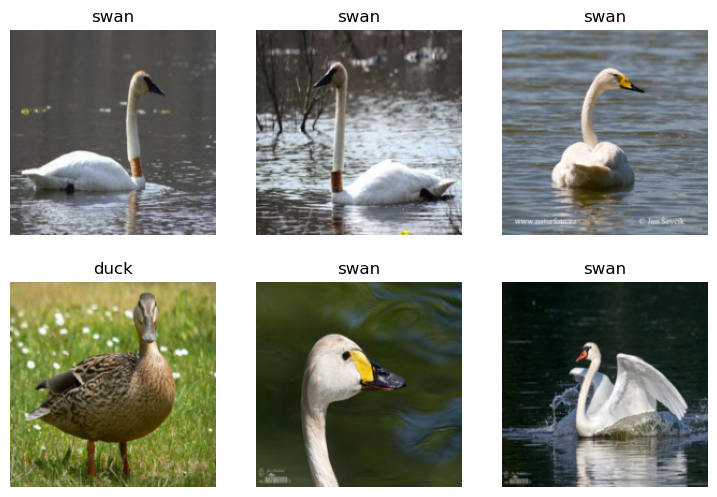

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

#### Fine tune the pre-trained `resnet18` model for our data.

In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/Users/bnabi/miniforge3/envs/invokeai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/bnabi/miniforge3/envs/invokeai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.222246,0.440960,0.290323,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.402388,0.356703,0.193548,00:05
1,0.249177,0.256310,0.064516,00:05
2,0.192781,0.251938,0.032258,00:05


#### Testing the images

In [10]:
bird,_,probs = learn.predict(PILImage.create('duck.jpg'))
Image.open('duck.jpg').to_thumb(256,256)
print(f"This is a: {bird}.")
print(f"Probability it's a duck: {probs[0]:.4f}")
print(f"Probability it's a swan: {probs[1]:.4f}")

This is a: duck.
Probability it's a duck: 0.9990
Probability it's a swan: 0.0010


In [11]:
bird,_,probs = learn.predict(PILImage.create('swan.jpg'))
Image.open('duck.jpg').to_thumb(256,256)
print(f"This is a: {bird}.")
print(f"Probability it's a duck: {probs[0]:.4f}")
print(f"Probability it's a swan: {probs[1]:.4f}")

This is a: swan.
Probability it's a duck: 0.0006
Probability it's a swan: 0.9994
